In [1]:
"""
BFR
"""
"""
code reference:
https://github.com/Yuhan-Wg/massive-data-mining/blob/master/python/datming/clustering/bfr.py
"""
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans


class BFR(object):
    class Local(object):
        def __init__(self, n_cluster, soft_n_cluster=None, shrink=0.5,
                     input_file_path=None, iter_func=None,
                     chunk_size=None, kmeans_params=None, print_log=True,
                     write_to_file=False, output_file=None, cache_labels=None):
            """
            :param n_cluster: int
            :param soft_n_cluster: int
                Used to roughly cluster points.
            :param shrink: float=0~1.0
                Used to reduce the threshold of Clustering Algorithm.
            :param input_file_path: str
                The file to read the input results.
                If parameter "data" is not specified, this parameter is used to build a generator.
            :param iter_func: function
                The function used to build iterator. The iterator returns pandas.DataFrame with index.
            :param output_file_path: str
                The file to store the output results.

            """
            self._n_cluster = n_cluster
            self._soft_n_cluster = soft_n_cluster if soft_n_cluster is not None else n_cluster ** 2
            self._shrink = shrink
            self._print_log = print_log
            self._data_generator = None
            self.clusters = self.labels = None
            self._write_to_file, self._output_file = write_to_file, output_file
            if cache_labels is None:
                self._cache_labels = not write_to_file
            else:
                self._cache_labels = cache_labels

            if isinstance(kmeans_params, dict):
                self._kmeans_params = kmeans_params
            else:
                self._kmeans_params = {}

            if input_file_path is None and iter_func is None:
                print("No data input. Please call add_data(generator) to add data to the model.")
            else:
                self.add_data(iter_func=iter_func, input_file_path=input_file_path, chunk_size=chunk_size)

        def add_data(self, iter_func, input_file_path, chunk_size):
            """
            :param input_file_path: str
            :param iter_func: function
            :param chunk_size: int
            """
            if callable(iter_func):
                self._data_generator = iter_func
            elif isinstance(input_file_path, str):
                self._data_generator = lambda: pd.read_table(input_file_path,
                                                             delimiter=",", dtype=np.float64,
                                                             chunksize=chunk_size)
            else:
                raise ValueError

        def run(self):
            """
            DS: (n_clusters, [n, SUM, SUM_SQUARE])
            CS: (n_clusters, [n, SUM, SUM_SQUARE])
            RS: (n_samples, dimension)
            """
            iterator_vectors = self._data_generator()
            vectors = next(iterator_vectors)
            n_dim = vectors.shape[1]
            """
            Initialize DS, CS, RS.
            """
            DS, CS, RS = self._initialization(vectors, n_dim)
            if self._print_log:
                print("Tasks start. Start to print intermediate results ...")
                self.print_log(1, DS, CS, RS)

            """
            Iteratively process chunks
            """
            for i, vectors in enumerate(iterator_vectors):
                DS, CS, RS = self._iteration(vectors, n_dim, DS, CS, RS)
                if self._print_log:
                    self.print_log(i+2, DS, CS, RS)

            DS, CS = self._last_round(DS, CS, n_dim)
            self.clusters = DS[:, 1:n_dim + 1]
            if self._print_log:
                self.print_log("final", DS, CS, RS)

            """
            Save the results: cluster coordinates and point labels.
            """
            if self._cache_labels and self._write_to_file:
                self.labels = pd.concat(list(self.classify(DS, self._n_cluster, n_dim)))
                self.labels.to_csv(self._output_file, mode="w", sep=",")
            elif self._cache_labels:
                self.labels = pd.concat(list(self.classify(DS, self._n_cluster, n_dim)))
            elif self._write_to_file:
                pd.DataFrame(columns=["cluster"]).to_csv(self._output_file, mode='w', sep=",", header=True)
                for df in self.classify(DS, self._n_cluster, n_dim):
                    df.to_csv(self._output_file, mode='a', sep=",", header=False)
            self.DS = DS
            self.RS = RS
            self.CS = CS
            return self

        @staticmethod
        def print_log(i, DS, CS, RS):
            print("Round {0}: \n"
                  "     Number of points in DS = {1}\n"
                  "     Number of clusters in CS = {2}\n"
                  "     Number of points in CS = {3},\n"
                  "     Number of points in RS = {4}".format(i,
                                                             int(np.sum(DS[:, 0])), CS.shape[0],
                                                             int(np.sum(CS[:, 0])), RS.shape[0]))

        def _initialization(self, vectors, n_dim):
            """
            :param vectors: pandas.DataFrame
            :param n_dim: int
            :return:
            """
            # Step 2-3
            rest, RS = self._initialize_RS(vectors=vectors,
                                           soft_n_cluster=self._soft_n_cluster,
                                           shrink=self._shrink,
                                           kmeans_params=self._kmeans_params)
            # Step 4-5
            DS = self._initialize_DS(vectors=rest,
                                     n_cluster=self._n_cluster,
                                     n_dim=n_dim,
                                     kmeans_params=self._kmeans_params)
            # Step 6
            CS, RS = self._initialize_CS(vectors=RS,
                                         n_cluster=self._soft_n_cluster,
                                         n_dim=n_dim,
                                         kmeans_params=self._kmeans_params)
            return DS, CS, RS

        def _iteration(self, vectors, n_dim, DS, CS, RS):
            # Update DS
            DS, vectors = self._update_DS_or_CS(vectors, DS, n_dim)
            # Update CS
            CS, vectors = self._update_DS_or_CS(vectors, CS, n_dim)
            # Update RS and CS
            CS, RS = self._update_RS(vectors, CS, RS, self._soft_n_cluster, n_dim, self._kmeans_params)
            # Merge clusters in CS
            CS = self._merge_CS(CS, n_dim)
            return DS, CS, RS

        def _last_round(self, DS, CS, n_dim):
            """
            Merge CS into DS if the clusters have a Mahalanobis Distance < 2 * sqrt(d)
            :return: DS, new_CS(just for print log)
            """
            num_points = np.sum(DS[:, 0]) + np.sum(CS[:, 0])
            for i in range(CS.shape[0]):
                distance = float("inf")
                for j in range(DS.shape[0]):
                    dist_ = self.dist(CS[i, :], DS[j, :], n_dim)
                    if dist_ < distance:
                        distance = dist_
                        min_j = j
                DS[min_j, :] += CS[i, :]
            new_CS = np.array([[num_points - np.sum(DS[:, 0])]])
            return DS, new_CS

        @staticmethod
        def _initialize_RS(vectors, soft_n_cluster, shrink, kmeans_params):
            """
            Initialize RS:
                Run KMeans algorithm to cluster the points.
                Filter out small clusters and add their members to RS.
                Rest points are used to build DS.
            :param vectors: pandas.DataFrame
            :param soft_n_cluster: int
            :param shrink: float
            :param kmeans_params: dict
            :return:
            """
            """
            Run the KMeans algorithm with a large K to cluster points.
            """
            threshold = int(vectors.shape[0] // soft_n_cluster * shrink)
            clusters = KMeans(n_clusters=soft_n_cluster, **kmeans_params)\
                .fit_predict(vectors)

            """
            Find out cluster members.
            Compute the statistics of clusters (number of points in each cluster) 
            then assign the number to each point.
            """
            # centroids and number of points in each cluster
            uniques, n_uniques = np.unique(clusters, return_counts=True)

            # count number of points in clusters
            count_table = dict(zip(uniques, n_uniques))
            vectorized_func = np.vectorize(lambda x: count_table[x])
            vector_nums = vectorized_func(clusters)

            """
            Construct RS and rest points(used to build DS)
            """
            RS = vectors[vector_nums <= threshold]
            rest = vectors[vector_nums > threshold]
            return rest, RS

        @staticmethod
        def _initialize_DS(vectors, n_cluster, n_dim, kmeans_params):
            """
            Initialize DS:
                Run KMeans and then compute statistics of each cluster.
            :param vectors: np.array
            :param n_cluster: int
            :param n_dim: int
            :param kmeans_params: dict
            :return: np.array
            """
            """
            Run KMeans and predict cluster index for each points
            """
            clusters = KMeans(n_clusters=n_cluster, **kmeans_params)\
                .fit_predict(vectors)

            """
            Calculate statistics.
            """
            DS = np.zeros((n_cluster, n_dim * 2 + 1))
            for idx, u in enumerate(np.unique(clusters, return_counts=False)):
                temp = vectors[clusters == u]
                DS[idx, 0] = temp.shape[0]
                DS[idx, 1: n_dim + 1] = np.sum(temp, axis=0)
                DS[idx, n_dim + 1: 2 * n_dim + 1] = np.sum(temp ** 2, axis=0) + 10**-6
            return DS

        @staticmethod
        def _initialize_CS(vectors, n_cluster, n_dim, kmeans_params):
            """
            Divide the RS into a new RS and CS.
                Run KMeans to cluster points in RS.
                Add points in the clusters with more than one member into RS, and rest into CS.
            :param vectors: np.array
                RS from _initialize_RS(...)
            :param n_cluster: int
            :param n_dim: int
            :param kmeans_params: dict
            :return:
            """
            if vectors.shape[0] <= n_cluster:
                return np.zeros((0, n_dim * 2 + 1)), vectors

            """
            Run KMeans.
            """
            arr_clusters = KMeans(n_clusters=n_cluster, **kmeans_params).fit_predict(vectors)
            uniques, n_uniques = np.unique(arr_clusters, return_counts=True)

            """
            Count the number of points in clusters.
            """
            count_table = dict(zip(uniques, n_uniques))
            vectorized_func = np.vectorize(lambda x: count_table[x])
            arr_nums = vectorized_func(arr_clusters)

            RS = vectors[arr_nums <= 1]

            CS = np.zeros((np.sum(n_uniques > 1), n_dim * 2 + 1))
            for i, u in enumerate(uniques[n_uniques > 1]):
                temp = vectors[arr_clusters == u]
                CS[i, 0] = temp.shape[0]
                CS[i, 1:n_dim + 1] = np.sum(temp, axis=0)
                CS[i, n_dim + 1:2 * n_dim + 1] = np.sum(temp ** 2, axis=0)
            return CS, RS

        @staticmethod
        def _update_DS_or_CS(vectors, clusters, n_dim):
            """
            Update DS: Add new points into DS or CS.
                For the new points, compare them to each of the DS using the Mahalanobis Distance and assign
                them to the nearest DS clusters if the distance is < 2 * sqrt(n_dim).
                For the new points that are not assigned to DS clusters, using the Mahalanobis Distance
                and assign the points to the nearest CS clusters if the distance is  < 2 * sqrt(n_dim).
            """
            if clusters.shape[0] == 0:
                return clusters, vectors
            """
            Initialize centers and variances of clusters.
            """
            centers = clusters[:, 1:n_dim + 1] / clusters[:, :1]
            variance = clusters[:, n_dim + 1:2 * n_dim + 1] / clusters[:, :1] - centers ** 2
            centers = centers.reshape((1, -1, n_dim))
            variance = variance.reshape((1, -1, n_dim))

            """
            Calculate Mahalanobis distances between points and clusters centers.
            And assign points into DS according to distances.
            """
            # distances.shape -> (n_samples, n_clusters)
            vectors = np.array(vectors)
            distance = np.sum((vectors.reshape((-1, 1, n_dim)) - centers) ** 2 / variance, axis=2) ** 0.5
            dist_argmin = np.argmin(distance, axis=1)
            dist_min = np.min(distance, axis=1)
            for i in range(clusters.shape[0]):
                temp = vectors[(dist_min <= 2 * np.sqrt(n_dim)) & (dist_argmin == i)]
                clusters[i, 0] += temp.shape[0]
                clusters[i, 1:n_dim + 1] += np.sum(temp, axis=0)
                clusters[i, n_dim + 1:2 * n_dim + 1] += np.sum(temp ** 2, axis=0)
            return clusters, vectors[(dist_min > 2 * np.sqrt(n_dim))]

        @staticmethod
        def _update_RS(vectors, CS, RS, n_cluster, n_dim, kmeans_params):
            """
            Update RS: And remain points into RS and re-assing points in RS and CS.
                For the new points that are not assigned to a DS cluster or a CS cluster, assign them to RS.
                Run K-Means on the RS with a large K to generate CS (clusters with more than one points)
                and RS (clusters with only one point).
            """
            RS = np.concatenate((vectors, RS), axis=0)
            if RS.shape[0] <= n_cluster:
                return CS, RS

            """
            Cluster RS and build new clusters in CS.
            """
            clusters = KMeans(n_clusters=n_cluster, **kmeans_params).fit_predict(RS)

            uniques, n_uniques = np.unique(clusters, return_counts=True)
            count_table = dict(zip(uniques, n_uniques))
            vectorized_func = np.vectorize(lambda x: count_table[x])
            vector_nums = vectorized_func(clusters)

            CS_more = np.zeros((np.sum(n_uniques > 1), n_dim * 2 + 1))
            for i, u in enumerate(uniques[n_uniques > 1]):
                temp = RS[clusters == u]
                CS_more[i, 0] = temp.shape[0]
                CS_more[i, 1:n_dim + 1] = np.sum(temp, axis=0)
                CS_more[i, n_dim + 1:2 * n_dim + 1] = np.sum(temp ** 2, axis=0)
            RS = RS[vector_nums <= 1]
            CS = np.concatenate((CS, CS_more), axis=0)
            return CS, RS

        def _merge_CS(self, CS, n_dim):
            """
            Merge clusters in CS that have a Mahalanobis Distance < 2 * sqrt(n_dim).
            """
            if CS.shape[0] < 2:
                return CS

            # flag represents weather two clusters have been merged in one loop
            flag = True
            while flag:
                flag = False
                for i in range(CS.shape[0] - 1):
                    for j in range(i + 1, CS.shape[0]):
                        if self.dist(CS[i, :], CS[j, :], n_dim) < 2 * np.sqrt(n_dim):
                            CS[i, :] += CS[j, :]
                            CS = np.delete(CS, j, axis=0)
                            flag = True
                            break
                    if flag:
                        break
            return CS

        @staticmethod
        def dist(cluster1, cluster2, n_dim):
            """
            Compute distance between two clusters
            :param cluster1: numpu.array
                shape = (1 + 2 * n_dim, )
                cluster: (n, SUM, SUMSQ)
            :param cluster2: same as cluster1
            :param n_dim: int
            :return:
            """
            c1 = cluster1[1:n_dim + 1] / cluster1[0]
            c2 = cluster2[1:n_dim + 1] / cluster2[0]
            v1 = cluster1[n_dim + 1:2 * n_dim + 1] / cluster1[0] - c1 ** 2
            return np.sum((c1 - c2) ** 2 / v1) ** 0.5

        def classify(self, DS, n_cluster, n_dim):
            """
            A new pass to assign points to clusters.
            :param DS:
            :param n_cluster:
            :param n_dim:
            :return:
            """
            iterator_vectors = self._data_generator()
            # centers and variance of clusters
            centers = DS[:, 1:n_dim + 1] / DS[:, :1]
            variance = DS[:, n_dim + 1:2 * n_dim + 1] / DS[:, :1] - centers ** 2
            centers = centers.reshape((1, -1, n_dim))
            variance = variance.reshape((1, -1, n_dim))

            for vectors in iterator_vectors:
                vector_index = vectors.index
                vectors = np.array(vectors)
                clusters = np.zeros((vectors.shape[0], 1))
                # distances.shape = (n_samples, n_clusters)
                distance = np.sum((vectors.reshape((-1, 1, n_dim)) - centers) ** 2 / variance, axis=2) ** 0.5
                dist_argmin = np.argmin(distance, axis=1)
                dist_min = np.min(distance, axis=1)
                for i in range(n_cluster):
                    clusters[(dist_min <= 4 * np.sqrt(n_dim)) & (dist_argmin == i)] = i
                    clusters[(dist_min > 4 * np.sqrt(n_dim))] = -1
                yield pd.DataFrame(clusters, index=vector_index, columns=["cluster"])

In [2]:
import time
if __name__ == '__main__':
    start = time.time()
    bfr = BFR.Local(n_cluster=10,input_file_path ='data_new.txt', chunk_size = 100000, print_log=True).run()
    print('Duration: %s' % (time.time() - start))
    print(bfr.clusters)
    # print(bfr.labels)

Tasks start. Start to print intermediate results ...
Round 1: 
     Number of points in DS = 100000
     Number of clusters in CS = 0
     Number of points in CS = 0,
     Number of points in RS = 0
Round 2: 
     Number of points in DS = 199289
     Number of clusters in CS = 83
     Number of points in CS = 711,
     Number of points in RS = 0
Round 3: 
     Number of points in DS = 298538
     Number of clusters in CS = 37
     Number of points in CS = 1424,
     Number of points in RS = 38
Round 4: 
     Number of points in DS = 397734
     Number of clusters in CS = 35
     Number of points in CS = 2228,
     Number of points in RS = 38
Round 5: 
     Number of points in DS = 496899
     Number of clusters in CS = 27
     Number of points in CS = 3061,
     Number of points in RS = 40
Round 6: 
     Number of points in DS = 596092
     Number of clusters in CS = 23
     Number of points in CS = 3867,
     Number of points in RS = 41
Round 7: 
     Number of points in DS = 695279
 

In [3]:
centers = [bfr.DS[i][1:4]/bfr.DS[i][0] for i in range(10)]

In [4]:
centers

[array([ 1.96934638, -6.87720776, -6.88119015]),
 array([-2.50831724,  9.01395853,  4.63954833]),
 array([ 4.15859026, -9.58838301,  9.39738958]),
 array([-6.33344226, -3.91959959,  0.47564411]),
 array([-0.87910644,  5.70126742, -6.00580369]),
 array([-8.8381668 ,  7.32340504,  2.02303077]),
 array([ 6.62228477, -5.75928284, -6.37257143]),
 array([-1.36115006, -4.17510036,  2.23886869]),
 array([-7.21028639, -4.15564311, -2.67080549]),
 array([ 0.27957264,  1.87365118, -9.05261494])]

In [10]:
# get clustering labels
labels = bfr.labels['cluster'].to_list()

In [6]:
from sklearn.datasets import make_blobs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
# how we generate data_new.txt
n_samples=1000000
n_features=3
X, y = make_blobs(n_samples=n_samples,cluster_std=0.5, centers=10, n_features=n_features, random_state=42)

<ipython-input-11-6b38203d9660>:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  threedee = plt.figure(figsize=(12,10)).gca(projection='3d')


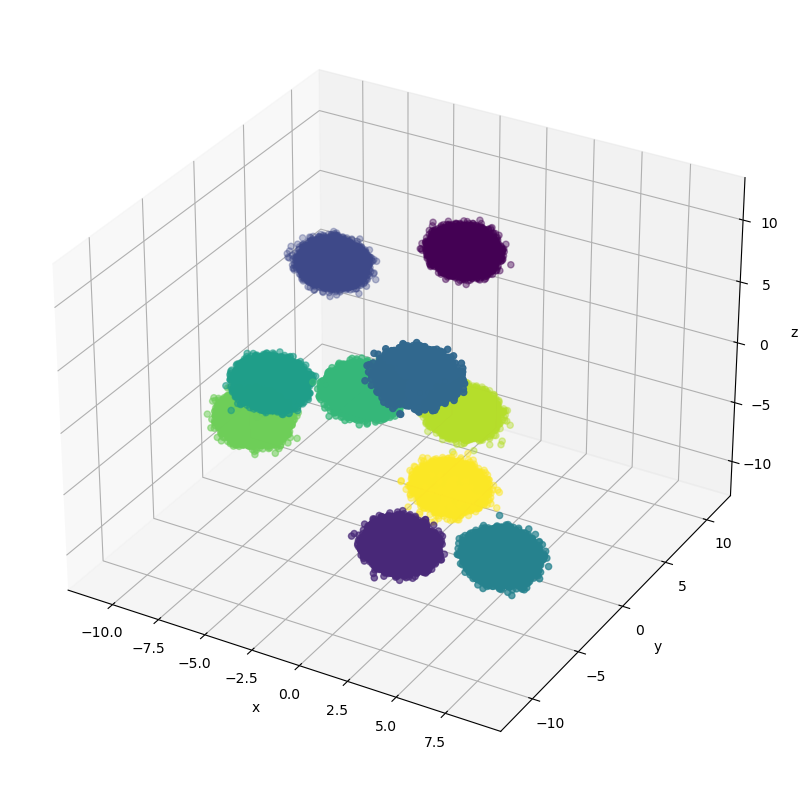

In [11]:
# plot ground truth
threedee = plt.figure(figsize=(12,10)).gca(projection='3d')
threedee.scatter(X[:,0], X[:,1], X[:,2], c=y)
threedee.set_xlabel('x')
threedee.set_ylabel('y')
threedee.set_zlabel('z')
plt.show()

<ipython-input-12-6c831694c280>:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  threedee = plt.figure(figsize=(12,10)).gca(projection='3d')


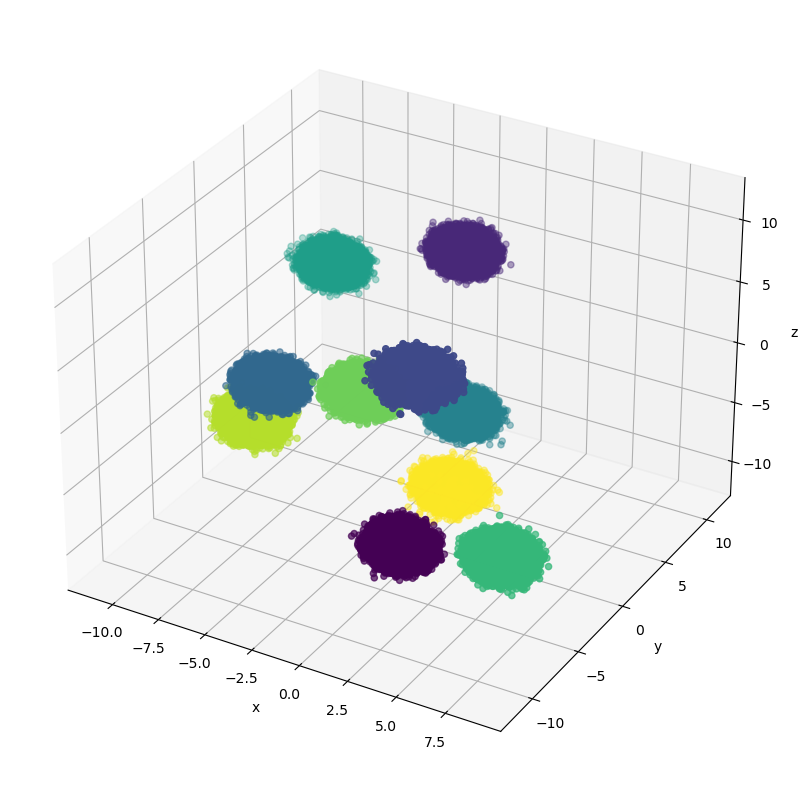

In [12]:
# plot clustering labels
threedee = plt.figure(figsize=(12,10)).gca(projection='3d')
threedee.scatter(X[:,0], X[:,1], X[:,2], c = labels)
threedee.set_xlabel('x')
threedee.set_ylabel('y')
threedee.set_zlabel('z')
plt.show()